# Accumulator Validation Working File

Validation report [here](https://github.com/regentmarkets/quants-model-validation/blob/master/Validation/Products/Accumulators%20(Synthetics)/README.md).



# Validation

#### configuration (yaml) file and the necessary library for this validation:

In [4]:
import pandas as pd
import numpy as np

import yaml
import json


from scipy.stats import norm
from scipy.optimize import fsolve

from os.path import exists

import websocket
import time

import matplotlib.pyplot as plt


In [5]:
#this is the value used in the configuration

with open("default_tick_size_barrier_accumulator.yml", 'r') as yaml_in:
    yaml_object = yaml.safe_load(yaml_in) 

 
## Test and Results
### Tick Size Barrier validation
The process involves a thorough comparison of the calculated value with the value utilized in production to identify any potential discrepancies.

This helps to ensure that the outputs meet the desired standards and specifications, and any deviations are addressed accordingly.

### Tick Size Barrier General Formula

$$\begin{align*}
P(\text{Loss}) &= P\left(\frac{S_t - S_{t-1}}{S_{t-1}} > b\right) + P\left(\frac{S_t - S_{t-1}}{S_{t-1}} < -b\right) \\
& = P\left(\frac{S_t}{S_{t-1}} > 1 + b\right) + P\left(\frac{S_t}{S_{t-1}} < 1 - b\right) \\
& = P\left(\ln\frac{S_t}{S_{t-1}} > \ln(1 + b)\right) + P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 - b)\right) \\
& = 1 - P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 + b)\right) + P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 - b)\right)
\end{align*} $$


### Tick Size Barrier for Vol Indices


#### Calculation of tick size barrier for Volatility Indices

We know that

$\ln\left(\frac{S_t}{S_{t-1}}\right) \sim N\left(-\frac{\sigma^2 dt}{2}, \sigma^2 dt\right) $

Thus,
$$P(\text{Loss}) = 1 - N\left(\frac{\ln(1+b)+\frac{\sigma^2 dt}{2}}{\sigma \sqrt{dt}}\right)+N\left(\frac{\ln(1-b)+\frac{\sigma^2 dt}{2}}{\sigma \sqrt{dt}}\right)$$


The equation is written in python below:

In [4]:
def gbm_R(b, *kwargs): #R_10 R_25 R_50 R_100
    loss_prob, sigma = kwargs
    t = 2/365/24/3600

    mu = -0.5*sigma**2*t
    sd = sigma**2*t

    prob_b1 = 1 - norm.cdf((np.log(1+b)-mu)/np.sqrt(sd))
    prob_b2 = norm.cdf((np.log(1-b)-mu)/np.sqrt(sd))

    return (prob_b1 + prob_b2 - loss_prob)

def gbm_1HZ(b, *kwargs): #1HZ10V 1HZ25V R1HZ50 1HZ10V0
    loss_prob, sigma = kwargs
    t = 1/365/24/3600

    mu = -0.5*sigma**2*t
    sd = sigma**2*t

    prob_b1 = 1 - norm.cdf((np.log(1+b)-mu)/np.sqrt(sd))
    prob_b2 = norm.cdf((np.log(1-b)-mu)/np.sqrt(sd))

    return (prob_b1 + prob_b2 - loss_prob)


In [5]:
growth_rate= np.arange(0.01,0.06,0.01)
vol=[0.1,0.25,0.5,0.75,1.0]

tick_size_barrier_R= pd.DataFrame(index=growth_rate,columns=vol)
tick_size_barrier_1HZ= pd.DataFrame(index=growth_rate,columns=vol)

for gr in growth_rate:
    for v in vol:
        tick_size_barrier_R.loc[gr,v] =  fsolve(gbm_R, 0, args = (gr, v))[0]
        tick_size_barrier_1HZ.loc[gr,v] =  fsolve(gbm_1HZ, 0, args = (gr, v))[0]

print(tick_size_barrier_1HZ)
print(tick_size_barrier_R)

          0.10      0.25      0.50      0.75      1.00
0.01  0.000046  0.000115  0.000229  0.000344  0.000459
0.02  0.000041  0.000104  0.000207  0.000311  0.000414
0.03  0.000039  0.000097  0.000193   0.00029  0.000386
0.04  0.000037  0.000091  0.000183  0.000274  0.000366
0.05  0.000035  0.000087  0.000175  0.000262  0.000349
          0.10      0.25      0.50      0.75      1.00
0.01  0.000065  0.000162  0.000324  0.000487  0.000649
0.02  0.000059  0.000146  0.000293  0.000439  0.000586
0.03  0.000055  0.000137  0.000273   0.00041  0.000546
0.04  0.000052  0.000129  0.000259  0.000388  0.000517
0.05  0.000049  0.000123  0.000247   0.00037  0.000494




#### Volatility Indices comparison
<img src="./docs/R_barrier.png" alt="vol 1s results" />

#### Volatility (1s) Indices comparison
<img src="./docs/1HZ_barrier.png" alt="vol 1s results" />



### Tick Size Barrier for Jump Indices


#### Calculation of tick size barrier for Jump Indices
$ \text{For our jump process, let } P = \frac{72}{86400}e^\frac{-72}{86400} $

The Jump Index is distributed as follow:
$$ \begin{array}{ll}
\ln\left(\frac{S_t}{S_{t-1}}\right) \sim N\left(-\frac{901\sigma^2 dt}{2}, 901\sigma^2 dt\right) & ,\text{if } U < P \\
\ln\left(\frac{S_t}{S_{t-1}}\right) \sim N\left(-\frac{\sigma^2 dt}{2}, \sigma^2 dt\right) & ,\text{if } U > P 
\end{array}$$

We can obtain, 
$$\begin{align*}
P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 + b)\right) & = P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 + b) \middle| \space U < P\right) * P(U < P) + P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 + b) \middle| \space U > P\right) * P(U > P) \\
& = N\left(\frac{\ln(1+b)+\frac{901\sigma^2 dt}{2}}{\sigma \sqrt{901dt}}\right) * P + N\left(\frac{\ln(1+b)+\frac{\sigma^2 dt}{2}}{\sigma \sqrt{dt}}\right) * (1 - P)
\end{align*}$$

Similarly, for the other term, 
$$\begin{align*}
P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 - b)\right) &= P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 - b) \middle| \space U < P\right) * P(U < P) + P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 - b) \middle| \space U > P\right) * P(U > P) \\
& = N\left(\frac{\ln(1-b)+\frac{901\sigma^2 dt}{2}}{\sigma \sqrt{901dt}}\right) * P + N\left(\frac{\ln(1-b)+\frac{\sigma^2 dt}{2}}{\sigma \sqrt{dt}}\right) * (1 - P)
\end{align*}$$

Thus, 
$$\begin{align*}
P(\text{Loss}) = & \space1 - N\left(\frac{\ln(1+b)+\frac{901\sigma^2 dt}{2}}{\sigma \sqrt{901dt}}\right) * P - N\left(\frac{\ln(1+b)+\frac{\sigma^2 dt}{2}}{\sigma \sqrt{dt}}\right) * (1 - P) \\
&+ N\left(\frac{\ln(1-b)+\frac{901\sigma^2 dt}{2}}{\sigma \sqrt{901dt}}\right) * P + N\left(\frac{\ln(1-b)+\frac{\sigma^2 dt}{2}}{\sigma \sqrt{dt}}\right) * (1 - P)
\end{align*}$$

The equation is written in python below:

In [7]:

def jump(x, *kwargs):
    loss_prob, sigma = kwargs
    P = 72/86400*np.exp(-72/86400)
    t = 1/365/24/3600

    mu = -0.5*sigma**2*t
    sd = sigma**2*t
    mu_jump = -0.5*901*sigma**2*t
    sd_jump = 901*sigma**2*t


    prob_b1 = 1- (norm.cdf((np.log(1+x)-mu)/np.sqrt(sd)) *(1 - P) + norm.cdf((np.log(1+x)-mu_jump)/np.sqrt(sd_jump)) * P)
    prob_b2 = norm.cdf((np.log(1-x)-mu)/np.sqrt(sd)) *(1 - P) + norm.cdf((np.log(1-x)-mu_jump)/np.sqrt(sd_jump)) * P
    return (prob_b1 + prob_b2 - loss_prob)


In [8]:
growth_rate= np.arange(0.01,0.06,0.01)
vol=[0.1,0.25,0.5,0.75,1.0]

tick_size_barrier_jump= pd.DataFrame(index=growth_rate,columns=vol)

for gr in growth_rate:
    for v in vol:
        tick_size_barrier_jump.loc[gr,v] = fsolve(jump, 0, args = (gr,v))[0]

print(tick_size_barrier_jump)

          0.10      0.25      0.50      0.75      1.00
0.01  0.000046  0.000116  0.000232  0.000348  0.000464
0.02  0.000042  0.000104  0.000208  0.000313  0.000417
0.03  0.000039  0.000097  0.000194  0.000291  0.000388
0.04  0.000037  0.000092  0.000184  0.000275  0.000367
0.05  0.000035  0.000088  0.000175  0.000263   0.00035



#### Jump Indices comparison

ps; 3rd column is calculated value, 4th column is the value used in configuration.

<img src="./docs/JD_barrier.png" alt="vol 1s results" />


### Tick Size Barrier for Crash/Boom Indices

#### Calculation of tick size barrier for Crash/Boom Indices
$$ \begin{align*}
\text{Let } P &= \text{up probability} \\
1 - P &= \text{down probability}
\end{align*}$$

$$ P(\text{Loss}) \text{ consists of} 
 \begin{array}{ll} 
P\left(\ln\frac{S_t}{S_{t-1}} > \ln(1 + b)\right), \text{this only happens when no crash/boom happens with probability } P \\
P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 - b)\right), \text{this only happens when crash/no boom happens with probability } 1 - P 
\end{array} . $$ 

In other words,
$$\begin{align*}
P(\text{Loss}) &= P\left(\ln\frac{S_t}{S_{t-1}} > \ln(1 + b)\right) + P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 - b)\right)  \\
&= P\left(\ln\frac{S_t}{S_{t-1}} > \ln(1 + b)\middle| \space U < P \right) * P(U < P) + P\left(\ln\frac{S_t}{S_{t-1}} < \ln(1 - b) \middle| \space U > P \right) * P(U > P) \\
&= P\left(\frac{MUT |N(1,1)|\sqrt{dt}}{\mu} > \ln(1 + b) \right) * P + P\left(\frac{MDT |N(1,1)|\sqrt{dt}}{\mu} < \ln(1 - b)\right) * (1 - P) \\
&= P\left(|N(1,1)| > \frac{\ln(1 + b)\mu}{MUT\sqrt{dt}} \right) * P + P\left(|N(1,1)| < \frac{\ln(1 - b)\mu}{MDT \sqrt{dt}}\right) * (1 - P) \\
&= \left(P\left(N(1,1) < -\frac{\ln(1 + b)\mu}{MUT\sqrt{dt}} \right) + P\left(N(1,1) > \frac{\ln(1 + b)\mu}{MUT\sqrt{dt}} \right)\right) * P + \left(P\left(N(1,1) > -\frac{\ln(1 - b)\mu}{MDT \sqrt{dt}}\right) + P\left(N(1,1) < \frac{\ln(1 - b)\mu}{MDT \sqrt{dt}}\right)\right)* (1 - P) \\
&= \left(P\left(Z < -\frac{\ln(1 + b)\mu}{MUT\sqrt{dt}} - 1\right) + P\left(Z > \frac{\ln(1 + b)\mu}{MUT\sqrt{dt}} - 1 \right)\right) * P + \left(P\left(Z > -\frac{\ln(1 - b)\mu}{MDT \sqrt{dt}} - 1\right) + P\left(Z < \frac{\ln(1 - b)\mu}{MDT \sqrt{dt}} - 1\right)\right)* (1 - P) 
\end{align*}$$


The equation is written in python below:


In [9]:
def crash(x, *kwargs):
    loss_prob, symbol = kwargs
    t = 1/365/24/3600

    mu = np.sqrt(2/np.pi)*np.exp(-1/2)+1-2*norm.cdf(-1)

    if symbol == '1000':
        P = 0.999
        MUT = 0.00561999
        MDT = -5.619
    elif symbol == '500':
        P = 0.998
        MUT = 0.0112512
        MDT = -5.619
    elif symbol == '300':
        P = 0.9966666666666667
        MUT = 0.048802
        MDT = -14.619814
    else:
        raise "Implementation Error"

    prob_b1 = (1 - norm.cdf((np.log(1+x)*mu)/(MUT*np.sqrt(t))-1) + norm.cdf((-np.log(1+x)*mu)/(MUT*np.sqrt(t))-1)) * P
    prob_b2 =  (1 - norm.cdf((-np.log(1-x)*mu)/(MDT*np.sqrt(t))-1) + norm.cdf((np.log(1-x)*mu)/(MDT*np.sqrt(t))-1)) * (1-P)

    return (prob_b1 + prob_b2 - loss_prob)


def boom(x, *kwargs):
    loss_prob, symbol = kwargs
    t = 1/365/24/3600

    mu = np.sqrt(2/np.pi)*np.exp(-1/2)+1-2*norm.cdf(-1)

    if symbol == '1000':
        P = 0.001
        MUT = 5.619
        MDT = -0.00562827
    elif symbol == '500':
        P = 0.002
        MUT = 5.619
        MDT = -0.0112680
    elif symbol == '300':
        P = 0.0033333333333333335
        MUT = 14.619814
        MDT = -0.048990
    else:
        raise "Implementation Error"

    prob_b1 = (1 - norm.cdf((np.log(1-x)*mu)/(MUT*np.sqrt(t))-1) + norm.cdf((-np.log(1-x)*mu)/(MUT*np.sqrt(t))-1)) * P
    prob_b2 =  (1 - norm.cdf((-np.log(1+x)*mu)/(MDT*np.sqrt(t))-1) + norm.cdf((np.log(1+x)*mu)/(MDT*np.sqrt(t))-1)) * (1-P)

    return (prob_b1 + prob_b2 - loss_prob)



In [11]:
crashboom_symbols = ['300', '500', '1000']

tick_size_barrier_crash = pd.DataFrame(index = growth_rate, columns = crashboom_symbols)
tick_size_barrier_boom = pd.DataFrame(index = growth_rate, columns = crashboom_symbols)


for gr in growth_rate:
    for symbol in crashboom_symbols:
        tick_size_barrier_crash.loc[gr,symbol] = fsolve(crash, 0, args = (gr,symbol))[0]
        tick_size_barrier_boom.loc[gr,symbol] = fsolve(boom, 0, args = (gr,symbol))[0]

print(tick_size_barrier_crash)
print(tick_size_barrier_boom)

           300       500      1000
0.01  0.000026  0.000006  0.000003
0.02  0.000023  0.000005  0.000003
0.03  0.000022  0.000005  0.000002
0.04  0.000021  0.000005  0.000002
0.05   0.00002  0.000005  0.000002
           300       500      1000
0.01  0.000026  0.000006  0.000003
0.02  0.000023  0.000005  0.000003
0.03  0.000022  0.000005  0.000002
0.04  0.000021  0.000005  0.000002
0.05   0.00002  0.000005  0.000002



#### Crash Indices
<img src="./docs/CRASH_barrier.png" alt="vol 1s results" />

#### Boom Indices
<img src="./docs/BOOM_barrier.png" alt="vol 1s results" />



#### Key takeaway

Based on the analysis, the calculated value matches the production code value to a high degree of accuracy of **up to 8 decimal places** for all variables, with the exception of instrument Crash 300 and Boom 300 (growth rate 1% and 2%).

Nevertheless, The observed discrepancy is considered insignificant and falls within an **acceptable tolerance** range.



### Barrier Production Validation

As part of the validation testing process, the methodology employed entailed:
1. the streaming of the API to obtain the required value,
2. followed by an attempt to reproduce this value using historical data.
3. A comparative analysis of the resulting values was then carried out in order to identify any possible discrepancies.

It is worth noting that since the value utilized in production is not stored in the database, it was necessary to stream the API and check for each individual instrument and each growth rate(1%, 2%, 3% ,4%, 5%) to ensure the completeness and accuracy of the testing results.

However, given the time-consuming nature of covering all instruments and each growth rate (1%, 2%, 3% ,4%, 5%), a sample size was taken for the purpose of expediting the testing process.

To streamline the testing process, a homogenous sample was taken that covered each of the 10 different symbols and their respective growth rate. Each sample (eg: R_75, 3% growth rate) was streamed for a period of 10 minutes, with the resulting values for spot, upper barrier, and lower barrier being recorded in a CSV file.

Subsequently, the value of upper barrier and lower barrier were reproduced from the recorded spot value, resulting in calc_upper_barrier and calc_lower_barrier, respectively. These reproduced values were then compared against the originally recorded values for upper barrier and lower barrier, respectively.

Tested data: 
* 1HZ10V 1% 
* 1HZ50V 2% 
* 1HZ100V 3% 
* R_25 4% 
* R_75 5% 
* JD10 2% 
* JD50 3% 
* JD100 1% 
* CRASH300 4% 
* CRASH1000 5% 
* BOOM500 5% 

The results of the testing indicate that **no discrepancies** were identified between the reproduced calculated values and the originally recorded values for upper and lower barrier. 


### Python script to stream the barrier from our API

We do not save barrier feed in our database. So, we stream the barrier live and save it in csv file for validation later on.


In [1]:
def barrier_stream(amount, symbol, growth_rate, duration=300): #(1) to stream data (2) to save it in csv
    connection = websocket.create_connection(
    # f"wss://ws.binaryws.com/websockets/v3?app_id={app_id}"
    # f"wss://qa134.deriv.dev/websockets/v3?l=EN&app_id=1&brand=binary"
    "wss://ws.binaryws.com/websockets/v3?l=EN&app_id=1089"
)
    start_time = time.time()
    request = {
        "amount": amount,
        "basis": "stake",
        "contract_type": "ACCU",
        "currency": "USD",
        "growth_rate": growth_rate,
        "proposal": 1,
        "req_id": 16,
        "subscribe": 1,
        "symbol": symbol
    }
    df = pd.DataFrame(columns=["spot", "spot_time", "last_tick_epoch", "high_barrier", "low_barrier"])

    connection.send(json.dumps(request))
    while time.time() - start_time < duration:
        res = connection.recv()
        if res is None:
            break
        data = json.loads(res)
        if "error" in data:
            print("Error:", data["error"]["message"])
            connection.close()
            break
        elif data["msg_type"] == "proposal":
            response_data = {
            "spot": data["proposal"]["spot"],
            "spot_time": data["proposal"]["spot_time"],
            "last_tick_epoch": data["proposal"]["contract_details"]["last_tick_epoch"],
            "high_barrier": data["proposal"]["contract_details"]["high_barrier"],
            "low_barrier": data["proposal"]["contract_details"]["low_barrier"]
        }
            df = pd.concat([df, pd.DataFrame(response_data, index=[0])])
            print(data["proposal"])
    # df.to_csv(f"{symbol}_barrier_data.csv", index=False)

### Validation process:

In [15]:
def trun_n_d(n,d):
    return n*10**d/10**d

def check_barrier(symbol,growth_rate, threshold): # to compare the barrier in the stream with the expected one

    if exists(f"accumulator_barrier_data/{symbol}_{growth_rate}_barrier_data.csv") is False:
        return("no file")
    else:
        df = pd.read_csv(f"accumulator_barrier_data/{symbol}_{growth_rate}_barrier_data.csv")

        barrier_thickness = yaml_object[f"{symbol}"][f"growth_rate_{growth_rate}"]

        # add calculated barrier 
        df["calc_high_barrier"]= trun_n_d(df["spot"] + df["spot"]*barrier_thickness,3)
        df["calc_low_barrier"]= trun_n_d(df["spot"] - df["spot"]*barrier_thickness,3)

        df["high_barrier_diff"] = df["high_barrier"] / df["calc_high_barrier"] -1
        df["low_barrier_diff"] = df["low_barrier"] / df["calc_low_barrier"] -1
        def filter_dataframe(df):
            filtered_df = df[(df['high_barrier'] - df['calc_high_barrier'] > threshold) | (df['low_barrier'] - df['calc_low_barrier'] > threshold)]

            if len(filtered_df['spot']) == 0:
                return "no faulty barrier"
            if len(filtered_df['spot']) != 0:
                return filtered_df
        
        return filter_dataframe(df)

In [ ]:
symbols=["1HZ10V","1HZ25V","1HZ50V","1HZ75V","1HZ100V","R_10","R_25","R_50","R_75","R_100","JD10","JD25","JD50","JD75","JD100","CRASH300N","CRASH500","CRASH1000","BOOM300N","BOOM500","BOOM1000"]
growth_rate=[0.01,0.02,0.03,0.04,0.05]

for symbol in symbols:
    for gr in growth_rate:
        print(symbol,gr, check_barrier(symbol,gr,0.001))


### Payout per ticks Validation
The Payout for every ticks is given as:
$$ \text{Stake}*(1+\text{growth rate})^\text{tick passed} $$

As part of the validation testing process, the methodology employed entailed:
1. the streaming of the API to obtain the payout for everyticks.
2. Validate on the payouts.

No discrepencies or error found, all values fetched from API is as expected. Example of process and result:



### Python script to stream the open contract from our API

The payout can only be streamed after you buy a contract. so:
1. use your account and register for the api key from deriv's website.
2. using the api, buy the contract.
3. stream the open contract.

python script below:

In [16]:
api_token = "register_yours_on_deriv_website_and_use_it_here" #make sure to tick all the necessary to enable trading
app_id = 1089  # Replace with your app_id or leave as 1089 for testing.

connection = websocket.create_connection(
    # f"wss://ws.binaryws.com/websockets/v3?app_id={app_id}"
    # f"wss://qa134.deriv.dev/websockets/v3?l=EN&app_id=1&brand=binary"
    "wss://ws.binaryws.com/websockets/v3?l=EN&app_id=1089"
    # "wss://green.binaryws.com/websockets/v3?app_id=31063&l=EN&brand=deriv"
)

def auth_token(api_token):
    request_authorize = {
    "authorize": f"{api_token}"
    }
    connection.send(json.dumps(request_authorize))

    res = connection.recv()
    if res is None:
        print("error")
    data = json.loads(res)
    if "error" in data:
        print("Error:", data["error"]["message"])
        connection.close()
        
    elif data["msg_type"] == "authorize":
        print(data["authorize"])
            

def proposal_id(amount, growth_rate, symbol):
    request_proposal= {
        "amount": amount,
        "basis": "stake",
        "contract_type": "ACCU",
        "currency": "USD",
        "growth_rate": growth_rate,
        "proposal": 1,
        "req_id": 16,
        "subscribe": 1,
        "symbol": symbol,
        "limit_order":{"take_profit": amount*2}
    }
    connection.send(json.dumps(request_proposal))
    while True:
        res = connection.recv()
        if res is None:
            break
        data = json.loads(res)
        if "error" in data:
            print("Error:", data["error"]["message"])
            connection.close()
            break
        elif data["msg_type"] == "proposal":
            return(data['proposal']["id"])

def buy_contract(proposal_id, amount):
    request_buy={
        "buy":f"{proposal_id}",
        "price": amount
    }
    connection.send(json.dumps(request_buy))
    res = connection.recv()
    if res is None:
        print("error")
    data = json.loads(res)
    if "error" in data:
        print("Error:", data["error"]["message"])
        connection.close()
        
    elif data["msg_type"] == "buy":
        print(data["buy"])

def stream_open_contract(symbol, growth_rate):
    df = pd.DataFrame(columns=[ 'current_spot','low_barrier','high_barrier','bid_price', 'profit','profit_percentage','tick_passed', 'growth_rate'])
    request_open_contract={
        "proposal_open_contract": 1,
        "subscribe": 1
    }
    connection.send(json.dumps(request_open_contract))
    while True:
        res = connection.recv()
        if res is None:
            break
        data = json.loads(res)
        if "error" in data:
            print("Error:", data["error"]["message"])
            connection.close()
            break
        elif data["msg_type"] == "proposal_open_contract":
            
            response_data = {'current_spot':data["proposal_open_contract"] ['current_spot'],
                            'low_barrier' : data["proposal_open_contract"]["low_barrier"] if "low_barrier" in data["proposal_open_contract"] else '',
                            'high_barrier' : data["proposal_open_contract"]["high_barrier"] if "high_barrier" in data["proposal_open_contract"] else '',
                             'bid_price': data["proposal_open_contract"] ['bid_price']
                            , 'profit': data["proposal_open_contract"]['profit'],
                            'profit_percentage': data['proposal_open_contract']['profit_percentage'],
                            'tick_passed': data["proposal_open_contract"]['tick_passed']
                            , 'growth_rate': data["proposal_open_contract"]['growth_rate']
                            }
            df = pd.concat([df, pd.DataFrame(response_data, index=[0])])
            print(data['proposal_open_contract'])
            if 'audit_details' in data['proposal_open_contract']:
                break
        
    df.to_csv(f"accumulator_payout_data/accumulator_{symbol}_{growth_rate}_payout_data.csv", index=False)
        
def buy_stream(amount, growth_rate, symbol): #use this to buy contract and stream open contract, streamed data will be saved on csv file
    auth_token(api_token)
    time.sleep(1)
    buy_contract(proposal_id(amount, growth_rate, symbol),amount)
    time.sleep(1)
    stream_open_contract(symbol, growth_rate)

### Validation process

In [15]:
#to compare the payout streamed vs expected payout

def payout_validation(instrument, gr): 
    df = pd.read_csv(f"accumulator_payout_data/accumulator_{instrument}_{gr}_payout_data.csv")


    df['expected_bid_price'] = round(df['bid_price'].iloc[0]* (1 + df["growth_rate"])**(df["tick_passed"]-1),2)
    df['fair_price'] = round(df['bid_price'].iloc[0]/ (1 -df["growth_rate"])**(df["tick_passed"]-1),2)
    df['company_profit'] = -df['bid_price'] + df['fair_price']
    df["diff"] = df['bid_price'] - df['expected_bid_price']
    df = df.iloc[1:-2]
    if df["diff"].mean() == 0:
        print("payout is as expected")
    else:
        print(df["diff"])
    plt.title("payout per ticks")
    plt.plot(df['bid_price'])

payout is as expected


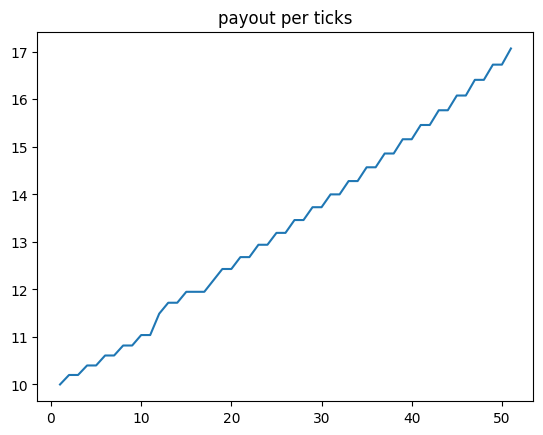

In [17]:
#example of result
#note that you need to stream the data and save the output in the csv file before you can validate it
payout_validation("1HZ50V",0.02)

### Survival Rate Validation

This process involves fetching historical data, reproducing upper and lower barriers, and checking the probability of survival for each instrument and growth rate.

The process include:
1. Data Retrieval: Historical data for a period of one month will be retrieved.
(you can use metabase/qabox/mt5)
2. Reproduction of Upper and Lower Barriers: The configuration on the YAML file in the production repository will be used to reproduce the upper and lower barriers. The formula for calculating the barriers is as follows: 

$$ \text{upper barrier} =  \text{spot price} * (1 + \text{barrier size}) $$
$$\text{lower barrier} =  \text{spot price} * (1 - \text{barrier size})$$

3. Probability Assessment: The probability of loss(or survival) for each instrument and group will be assessed and compared with the expected value. The expected value is nothing other than the growth rate it self. (for instrument with 0.01 growth rate, will have 0.99 survival rate)

The historical data used in this report is march 2023 data, Result is as follows:



In [3]:
growth_rate= np.arange(0.01,0.06,0.01)
symbols=["1HZ10V","1HZ25V","1HZ50V","1HZ75V","1HZ100V","R_10","R_25","R_50","R_75","R_100","JD10","JD25","JD50","JD75","JD100","CRASH300N","CRASH500","CRASH1000","BOOM300N","BOOM500","BOOM1000"]
for symbol in symbols:
    df = pd.read_csv(f"hist_data_202303/{symbol}_202303.csv")
    df.sort_values('ts', inplace=True)
    
    for gr in growth_rate:
        df[f'high_barrier_{gr}'] = df["spot"]*(1+yaml_object[f"{symbol}"][f"growth_rate_{gr}"])
        df[f'low_barrier_{gr}'] = df["spot"]*(1-yaml_object[f"{symbol}"][f"growth_rate_{gr}"])
        df[f'surv_{gr}'] = np.where((df["spot"] < df[f"high_barrier_{gr}"].shift(1)) & (df["spot"] > df[f'low_barrier_{gr}'].shift(1)), 1, 0)
        print(symbol, gr,"loss_prob", (1 - (df[f"surv_{gr}"]).mean()))
    print('------------')

1HZ10V 0.01 loss_prob 0.010235808564653115
1HZ10V 0.02 loss_prob 0.020336822437304614
1HZ10V 0.03 loss_prob 0.02997258925667634
1HZ10V 0.04 loss_prob 0.04045296990792513
1HZ10V 0.05 loss_prob 0.04995282185779948
------------
1HZ25V 0.01 loss_prob 0.00999870432802974
1HZ25V 0.02 loss_prob 0.019979485816125853
1HZ25V 0.03 loss_prob 0.029969228724188723
1HZ25V 0.04 loss_prob 0.04002543549700599
1HZ25V 0.05 loss_prob 0.0501025522497458
------------
1HZ50V 0.01 loss_prob 0.010099893695155626
1HZ50V 0.02 loss_prob 0.01998433991860793
1HZ50V 0.03 loss_prob 0.0300207568889983
1HZ50V 0.04 loss_prob 0.039970546799708906
1HZ50V 0.05 loss_prob 0.05010553938973472
------------
1HZ75V 0.01 loss_prob 0.00995053669570789
1HZ75V 0.02 loss_prob 0.019945880491250123
1HZ75V 0.03 loss_prob 0.02990985931690826
1HZ75V 0.04 loss_prob 0.03987682528255543
1HZ75V 0.05 loss_prob 0.04995655578278568
------------
1HZ100V 0.01 loss_prob 0.009973313638123704
1HZ100V 0.02 loss_prob 0.0200160782809905
1HZ100V 0.03 loss

### Convergence rate of accumulator

Having conducted an analysis of the survival rates for each instrument using data from March 2023, the next step is to evaluate the rate at which these survival rates converge towards the expected value. This analysis can provide valuable insights into the effectiveness of the current production process and help to identify any areas for improvement. 

Issue found:
* It takes longer time for the probability to converge for crash/boom instrument.

The results is as follows:


In [3]:
def plot_converge(underlying, gr, ym): 
    df = pd.read_csv(f"hist_data_{ym}/{underlying}_{ym}.csv")
    df.sort_values('ts', inplace=True,ignore_index=True)
    df.drop_duplicates()
    df.dropna()
    # df = df.reset_index(drop=True)
    df.drop(['Unnamed: 0','runbet_spot'], axis='columns', inplace=True)
    df[f'high_barrier_0.05'] = df["spot"]*(1+yaml_object[f"{underlying}"][f"growth_rate_{gr}"])
    df[f'low_barrier_0.05'] = df["spot"]*(1-yaml_object[f"{underlying}"][f"growth_rate_{gr}"])

    df[f'surv_0.05'] = np.where((df["spot"] <= df[f"high_barrier_0.05"].shift(1)) & (df["spot"] >= df[f'low_barrier_0.05'].shift(1)), 1, 0)
    df["cum_surv_0.05"] = df["surv_0.05"].cumsum()
    df["mean"] = df["cum_surv_0.05"]/df.index
   
    plt.plot(df["mean"].iloc[100:])
    plt.title("probabilty of survival vs time(ticks)")
    plt.axhline(y=1-gr, color='r', linestyle='-')
    plt.legend([], loc='best', title=underlying)


def plot_converge_CRASH1000():
    df = pd.read_csv(f"CRASH1000_2023/CRASH1000_combined_data.csv")
    df.sort_values('ts', inplace=True,ignore_index=True)
    df.drop_duplicates()
    df.dropna()
    # df = df.reset_index(drop=True)
    df.drop(['Unnamed: 0','runbet_spot'], axis='columns', inplace=True)
    df[f'high_barrier_0.05'] = df["spot"]*(1+yaml_object[f"CRASH1000"][f"growth_rate_0.02"])
    df[f'low_barrier_0.05'] = df["spot"]*(1-yaml_object[f"CRASH1000"][f"growth_rate_0.02"])

    df[f'surv_0.05'] = np.where((df["spot"] <= df[f"high_barrier_0.05"].shift(1)) & (df["spot"] >= df[f'low_barrier_0.05'].shift(1)), 1, 0)
    df["cum_surv_0.05"] = df["surv_0.05"].cumsum()
    df["mean"] = df["cum_surv_0.05"]/df.index
    # df.drop(["ts","bid","ask"	,"spot"	,"high_barrier_0.05"	,"low_barrier_0.05"	], axis='columns', inplace=True)
    # df['log_return']

    print(df[f'surv_0.05'].mean())
    plt.plot(df["mean"].iloc[100:])
    plt.legend([], loc='best', title='CRASH1000(4month)')
    plt.axhline(y=1-0.02, color='r', linestyle='-')
    plt.title("probabilty of survival vs time(ticks)")
    plt.figure(figsize=(12,8))

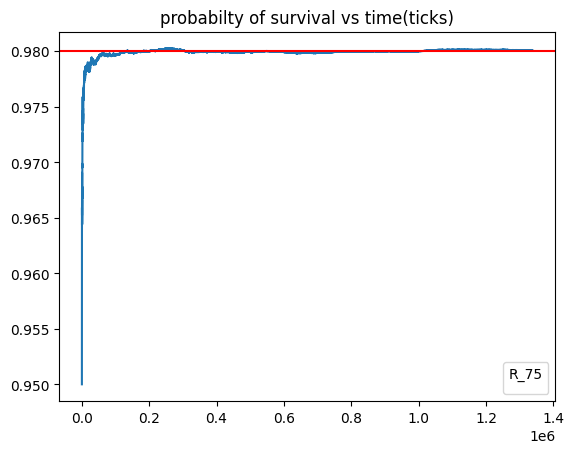

In [4]:
#example of result
#get the historical data vefore and save it in hist_data/<instrument>_<yyyymm>.csv file to use the function
plot_converge("R_75", 0.02, "202303")


0.9795030582926713


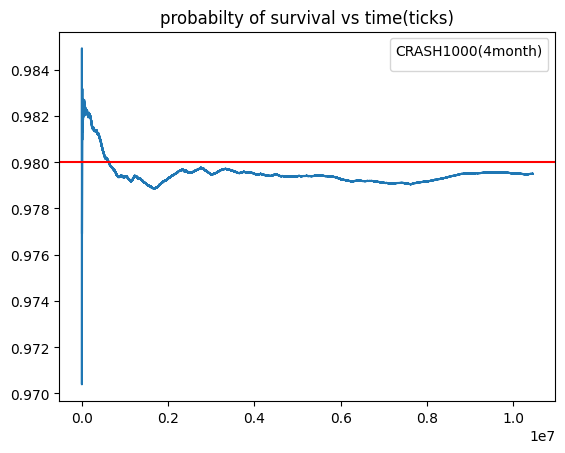

<Figure size 1200x800 with 0 Axes>

In [5]:
plot_converge_CRASH1000()

### Potential issue with Crash/Boom indices.

We check the distribution of return on Crash/Boom indices to see if there is any desprepencies.


### Strategy test on accumulator
A simple strategy was applied to each instrument, with both the win rate and PnL (profit and loss) of this strategy being evaluated for each instrument and growth rate provided.

#### Strategy 1:
Buy the contract every n ticks for 1 month no matter lose or win.


In [7]:
def strat_1(underlying, gr, stake, ticks):
    '''
    underlying : name of the underlying (eg: 1HZ100V, R_75, CRASH300N, BOOM1000, JD_75)
    gr : growth rate (1%, 2%, 3%, 4%, 5%) 
    stake : how much money the client put to buy the contracts
    ticks : how many ticks until the client sells accumulator option contract (min ticks = 1)
    '''
    
    df = pd.read_csv(f"hist_data_202303/{underlying}_202303.csv")
    df.drop(["bid","ask","Unnamed: 0","runbet_spot"], axis='columns', inplace=True)
    df[f'high_barrier'] = df["spot"]*(1+yaml_object[f"{underlying}"][f"growth_rate_{gr}"])
    df[f'low_barrier'] = df["spot"]*(1-yaml_object[f"{underlying}"][f"growth_rate_{gr}"])
    df[f'is_surv'] = np.where((df["spot"] <= df[f"high_barrier"].shift(1)) & (df["spot"] >= df[f'low_barrier'].shift(1)), 1, 0)
    df = df.iloc[1:]

    df['contract'] = df['is_surv'].rolling(window=ticks).apply(lambda x: sum(x), raw=True)

    df.loc[df.index % ticks != 0, 'contract'] = np.nan

    df["prob"] = np.where(df["contract"] != 0 , 0.99**5,0)

    df["pnl"] = np.where(df["contract"] == ticks, stake*(1 + float(gr))**ticks , np.where(df["contract"].isnull(), 0, 0))

    df2 = df[df["contract"].notnull()]

    result = {}
    result["average_PnL"] = df2["pnl"].sum()/df2.shape[0] - stake
    result["total_PnL (1 month)"] = df2["pnl"].sum()- stake*df2.shape[0]
    result["total_tries"] = df2.shape[0]
    result["total_wins"] = df2[df2["contract"] == ticks].shape[0]
    result["total_loses"] = df2[df2["contract"] != ticks].shape[0]
    result["win_rate"] = df2[df2["contract"] == ticks].shape[0]/ df2.shape[0]
    result["expected_win_rate"] = (1-float(gr))**ticks
    result["rel_diff"] = ((result["win_rate"]-result["expected_win_rate"])/result["expected_win_rate"])*100

    return result


def strat_1_pnl_conv(underlying, gr, stake, ticks):
    df = pd.read_csv(f"hist_data_202303/{underlying}_202303.csv")
    df.drop(["bid","ask","Unnamed: 0","runbet_spot"], axis='columns', inplace=True)
    df[f'high_barrier'] = df["spot"]*(1+yaml_object[f"{underlying}"][f"growth_rate_{gr}"])
    df[f'low_barrier'] = df["spot"]*(1-yaml_object[f"{underlying}"][f"growth_rate_{gr}"])
    df[f'is_surv'] = np.where((df["spot"] <= df[f"high_barrier"].shift(-1)) & (df["spot"] >= df[f'low_barrier'].shift(-1)), 1, 0)
    df = df.iloc[1:]

    df['contract'] = df['is_surv'].rolling(window=ticks).apply(lambda x: sum(x), raw=True)

    df.loc[df.index % ticks != 0, 'contract'] = np.nan

    df["prob"] = np.where(df["contract"] != 0 , (1-float(gr))**ticks,0)

    df["pnl"] = np.where(df["contract"] == ticks, stake*(1 + float(gr))**ticks - stake, np.where(df["contract"].isnull(), 0, - stake))

    df["cum_pnl"] = df["pnl"].cumsum()

    df2 = df[df["contract"].notnull()]

    df2.sort_values('ts', inplace=True,ignore_index=True)

    df2["avg_pnl"] = df2["pnl"].cumsum()/(df2.index + 1)

    df2["expected_pnl"] = df2["pnl"]* df2["prob"]

    df2["is_win"] = np.where(df2["contract"] == ticks, 1,0)
    df2["cumwin"] = df2["is_win"].cumsum()
                            
    df2["win_prob"] = df2["cumwin"]/ (df2.index +1)

    df2["expected_pnl2"] = df2["pnl"] * df2["win_prob"]

    expected_pnl = ((stake* (1+float(gr))**ticks - stake) * (1-float(gr))**ticks ) + -stake * (1- ((1-float(gr))**ticks))
    
    
    fig, axs = plt.subplots(2)
    fig.suptitle('PnL and average PnL')
    axs[0].plot(df2["cum_pnl"])
    axs[1].plot(df2["avg_pnl"].iloc[100:])
    axs[1].axhline(y=expected_pnl, color='r', linestyle='-')

In [7]:
rowth_rate = np.arange(0.01, 0.06, 0.01)
symbols = ["1HZ10V", "1HZ25V", "1HZ50V", "1HZ75V", "1HZ100V", "R_10", "R_25", "R_50", "R_75", "R_100", "JD10", "JD25", "JD50", "JD75", "JD100", "CRASH300N", "CRASH500", "CRASH1000", "BOOM300N", "BOOM500", "BOOM1000"]

def iterate_strat_1(stake, ticks):
    results = []

    for symbol in symbols:
        for gr in growth_rate:
                res = strat_1(symbol, f"{gr}", stake, ticks) # change the stake and ticks as per your requirement
                res_dict = {"symbol": symbol, "gr": gr, "avg_pnl": res["average_PnL"], "total_pnl_1m": res["total_PnL (1 month)"], "total_tries": res["total_tries"], "total_wins": res["total_wins"], "total_loses": res["total_loses"], "win_rate": res["win_rate"], "expected_win_rate": res["expected_win_rate"], "relative_difference": res["rel_diff"]}
                results.append(res_dict)
            

    df = pd.DataFrame(results)
    df.to_csv(f"strat_1_{stake}_{ticks}_results.csv", index=False)
    return df

## Example of results:

In [11]:
df = pd.read_csv("strat_1_100_43_results.csv")
df.head(10)

,symbol,gr,avg_pnl,total_pnl_1m,total_tries,total_wins,total_loses,win_rate,expected_win_rate,relative_difference
0,1HZ10V,0.01,-4.609743,-2.871040e+05,62282,38730,23552,0.621849,0.649103,-4.198661
1,1HZ10V,0.02,-6.839769,-4.259945e+05,62282,24762,37520,0.397579,0.419490,-5.223228
2,1HZ10V,0.03,-7.484645,-4.661586e+05,62282,16165,46117,0.259545,0.269889,-3.832443
3,1HZ10V,0.04,-11.858909,-7.385966e+05,62282,10165,52117,0.163209,0.172847,-5.576127
4,1HZ10V,0.05,-13.926160,-8.673491e+05,62282,6578,55704,0.105616,0.110183,-4.144665
5,1HZ25V,0.01,-5.117112,-3.187039e+05,62282,38524,23758,0.618541,0.649103,-4.708216
6,1HZ25V,0.02,-6.437211,-4.009224e+05,62282,24869,37413,0.399297,0.419490,-4.813684
7,1HZ25V,0.03,-8.388909,-5.224780e+05,62282,16007,46275,0.257008,0.269889,-4.772404
8,1HZ25V,0.04,-12.379171,-7.709995e+05,62282,10105,52177,0.162246,0.172847,-6.133474
9,1HZ25V,0.05,-17.354458,-1.080870e+06,62282,6316,55966,0.101410,0.110183,-7.962557


/tmp/ipykernel_6944/2630732480.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_values('ts', inplace=True,ignore_index=True)
/tmp/ipykernel_6944/2630732480.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["avg_pnl"] = df2["pnl"].cumsum()/(df2.index + 1)
/tmp/ipykernel_6944/2630732480.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

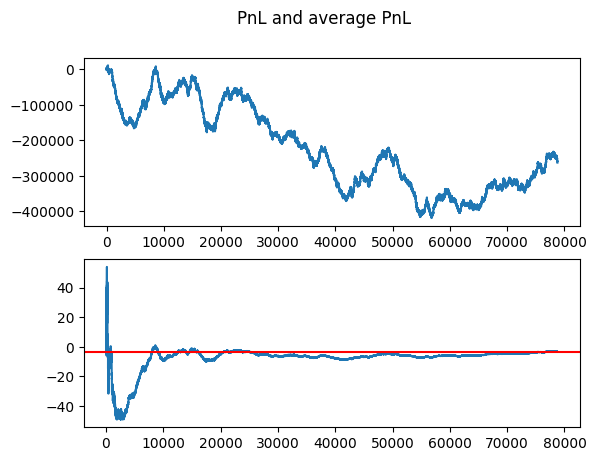

In [8]:
strat_1_pnl_conv("BOOM1000", gr="0.01", stake=1000, ticks=34)